# Convolutional Neural Networks

## Questions: 
- **At this point, what is the purpose of having train, validation, and test splits?**
    - Having the dataset split into train, validation, and test splits not only improves the performance of the model, but also gives status on the performance of the model during and after training. Train set is the one fed to the model. It is from where the model adjust its weights the most as it is presented in every epoch. To prevent overfitting, presenting data from the validation set to the trained model allows for detecting overfitting symptoms (bad results when presented with new data) early. Model parameters may be tweaked accordingly based on the result on validation set. Test set is presented to the model after the training. Since the data from test set are new to the model, it as great basis for the overall performance of the model.
    
    
- **When do you use categorical_cross_entropy as opposed to sparse_categorical_cross_entropy?**
    - Categorical_cross_entropy is typically used when there are more than two outputs from the model. Although it could also be used for outputs with two outputs such as this model below. Binary_cross_entropy with sigmoid activation is the alternative when there are only two classes. Sparse_categoroical_cross_entropy is used classes are mutually exclusives. Each sample belongs to only one single class. An example for this is the model at sequential.ipynb, where the data are integers. Categorical_cross_entropy is used in the model below because the data are images (2D array / matrix) which cannot be repesented by an integer but a hot encoded array.


- **Differentiate fine-tuning vs.training from scratch. Refer to fine-tuning use cases here: JLJqv.png (1249×558) (imgur.com) Which quadrant do the following use cases belong if we are using a VGG-16 pretrained on the ImageNet library:** 
    - **Classifying 50 breeds of dogs among millions of images** 
    - **Classifying banana leaf diseases from a small local dataset of 1000 images**
        - Fine-tuning model refers to the training of an existing model that had previous learning from data. It uses layers from the existing model and further trains its parameters. In simple terms, it builds on top of a previous model. On the other hand, a training model from scratch, as the name implies, uses a newly created model with no prior training.
        - Using a VGG-16 pre-trained model to classify 50 breeds of dogs among millions of images belonging to Quadrant 4. 50 breeds of dogs may seem small but, considering the millions of images and that the model must classify an image to be a dog, and specifically its breed requires a large data size. It was also stated in the tutorial video that the ImageNet library contains images of dogs in which VGG-16 was trained, meaning, the VGG-16 had prior knowledge on classifying dogs.
        - Using VGG-16 to classify banana leaf diseases from a small local dataset of 1000 images belongs to Quadrant 3. The data set is said to be small but assuming that the ImageNet library doesn't contain many images of banana leaves, then the model is not familiar with the dataset.


- **Given the confusion matrix, what is the formula for the accuracy rate?**
    - Given a confusion matrix, the formula for accuracy rate is the number of correct predictions divided by the number of predictions. The number of correct predictions can be seen as the sum of the predictions from the confusion matrix's diagonal from upper-most-left to lower-most-right. The number of predictions is the sum of all predictions seen in the confusion matrix.

In [175]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [176]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"Num of GPUs: {len(physical_devices)}")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num of GPUs: 1


## Data Preparation

In [177]:
# Organize data into train, valid, test dirs
# os.chdir("data/dogs-vs-cats")
# if os.path.isdir("train/dog") is False:
#     os.makedirs("train/dog")
#     os.makedirs("train/cat")
#     os.makedirs("valid/dog")
#     os.makedirs("valid/cat")
#     os.makedirs("test/dog")
#     os.makedirs("test/cat")

#     for cat_img in random.sample(glob.glob("cat*"), 500):
#         shutil.move(cat_img, "train/cat")
#     for dog_img in random.sample(glob.glob("dog*"), 500):
#         shutil.move(dog_img, "train/dog")
#     for cat_img in random.sample(glob.glob("cat*"), 100):
#         shutil.move(cat_img, "valid/cat")
#     for dog_img in random.sample(glob.glob("dog*"), 100):
#         shutil.move(dog_img, "valid/dog")
#     for cat_img in random.sample(glob.glob("cat*"), 50):
#         shutil.move(cat_img, "test/cat")
#     for dog_img in random.sample(glob.glob("dog*"), 50):
#         shutil.move(dog_img, "test/dog")

# os.chdir("../../")

In [178]:
train_path = "/kaggle/input/cats-vs-dogs-dataset/train"
valid_path = "/kaggle/input/cats-vs-dogs-dataset/valid"
test_path = "/kaggle/input/cats-vs-dogs-dataset/test"

In [179]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=["cat", "dog"], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["cat", "dog"], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=["cat", "dog"], batch_size=32, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [180]:
# assert train_batches.n == 1000
# assert valid_batches.n == 200
# assert test_batches.n == 100

print(train_batches.n) 
print (valid_batches.n)
print (test_batches.n)

1000
200
100


In [181]:
imgs, labels = next(train_batches)

In [182]:
# Plot the images in a form of grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

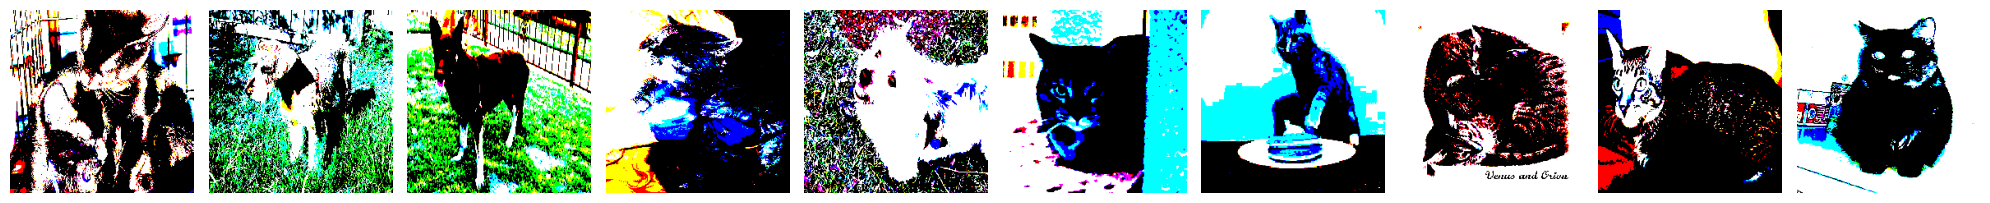

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [183]:
plotImages(imgs)
print(labels)

## Build and train CNN

In [184]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

In [185]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 200704)            0         
                                                                 
 dense_9 (Dense)             (None, 2)                

In [186]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [187]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
32/32 - 5s - loss: 47.2175 - accuracy: 0.5610 - val_loss: 25.1635 - val_accuracy: 0.5550 - 5s/epoch - 150ms/step
Epoch 2/10
32/32 - 4s - loss: 13.6269 - accuracy: 0.6570 - val_loss: 18.0744 - val_accuracy: 0.5600 - 4s/epoch - 117ms/step
Epoch 3/10
32/32 - 3s - loss: 7.6888 - accuracy: 0.7500 - val_loss: 13.1894 - val_accuracy: 0.5750 - 3s/epoch - 103ms/step
Epoch 4/10
32/32 - 3s - loss: 4.8396 - accuracy: 0.7970 - val_loss: 14.0926 - val_accuracy: 0.5850 - 3s/epoch - 104ms/step
Epoch 5/10
32/32 - 3s - loss: 4.2037 - accuracy: 0.8250 - val_loss: 14.7666 - val_accuracy: 0.5900 - 3s/epoch - 103ms/step
Epoch 6/10
32/32 - 3s - loss: 2.1334 - accuracy: 0.8770 - val_loss: 16.9214 - val_accuracy: 0.5750 - 3s/epoch - 104ms/step
Epoch 7/10
32/32 - 3s - loss: 2.1037 - accuracy: 0.8810 - val_loss: 17.5944 - val_accuracy: 0.6050 - 3s/epoch - 105ms/step
Epoch 8/10
32/32 - 3s - loss: 1.9189 - accuracy: 0.9000 - val_loss: 14.5755 - val_accuracy: 0.5850 - 3s/epoch - 102ms/step
Epoch 9/10
32/

### Then plot the train and valid accuracy on a graph:

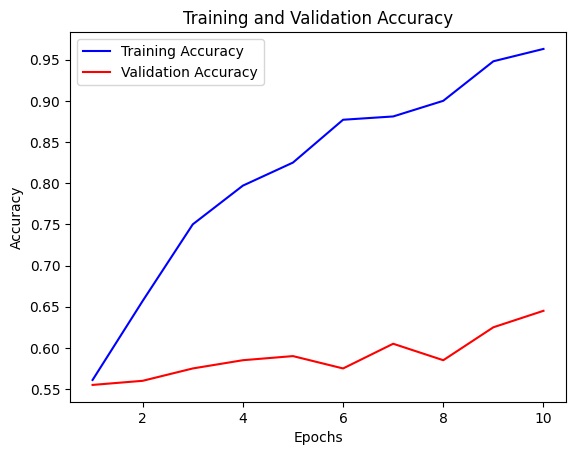

In [188]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)
# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b',label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

## Predict

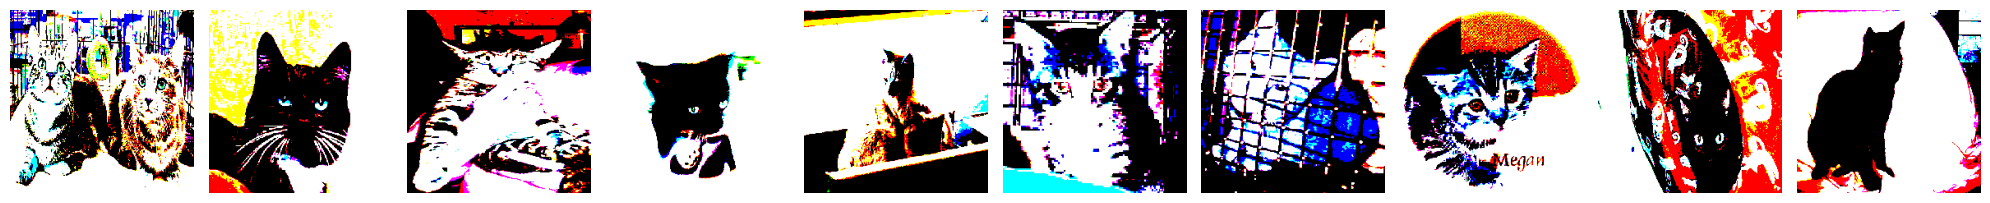

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [189]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [190]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [191]:
predictions = model.predict(x=test_batches, verbose=0)

In [192]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [193]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [194]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [195]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[32 18]
 [20 30]]


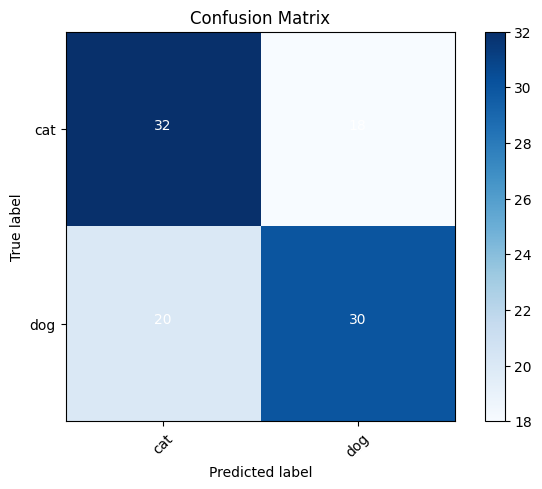

In [196]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [197]:
# # Given code snippet, there seems to be an error, iter not exhausting
# test_accuracy_values = []
# while True:
#     try:
#         test_data_batch, test_labels_batch = next(test_batches)
#         test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
#         test_accuracy_values.append(test_accuracy)
#     except StopIteration:
#         break # Break the loop when you've processed all batches

# # Calculate the overall test accuracy
# overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
# print("Overall Test Accuracy:", overall_test_accuracy)
   

test_accuracy_values = []
while len(test_accuracy_values) < test_batches.n:
    test_data_batch, test_labels_batch = next(test_batches)
    test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
    test_accuracy_values.append(test_accuracy)
    
# Calculate the overall test accuracy
overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
print("Overall Test Accuracy:", overall_test_accuracy)   


1/1 [==============================] - 0s 36ms/step - loss: 15.5285 - accuracy: 0.5625
Overall Test Accuracy: 0.703125


## Build Fine-tuned VGG16 model

In [198]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [199]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [200]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [201]:
params = count_params(vgg16_model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 138_357_544

In [202]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [203]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [204]:
params = count_params(model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 134_260_544

In [205]:
for layers in model.layers:
    layers.trainable = False

In [206]:
model.add(Dense(units=2, activation="softmax"))

In [207]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)     

In [208]:
params = count_params(model)
assert params["non_trainable_params"] == 134_260_544
assert params["trainable_params"] == 8_194 

## Train the fine-tuned VGG16 model

In [209]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [210]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
32/32 - 5s - loss: 1.2364 - accuracy: 0.6350 - val_loss: 0.7399 - val_accuracy: 0.7750 - 5s/epoch - 153ms/step
Epoch 2/10
32/32 - 4s - loss: 0.5372 - accuracy: 0.8350 - val_loss: 0.5698 - val_accuracy: 0.8200 - 4s/epoch - 117ms/step
Epoch 3/10
32/32 - 4s - loss: 0.4075 - accuracy: 0.8700 - val_loss: 0.5881 - val_accuracy: 0.8150 - 4s/epoch - 113ms/step
Epoch 4/10
32/32 - 4s - loss: 0.3459 - accuracy: 0.8860 - val_loss: 0.4673 - val_accuracy: 0.8350 - 4s/epoch - 111ms/step
Epoch 5/10
32/32 - 4s - loss: 0.2907 - accuracy: 0.9000 - val_loss: 0.4716 - val_accuracy: 0.8350 - 4s/epoch - 111ms/step
Epoch 6/10
32/32 - 4s - loss: 0.2658 - accuracy: 0.9070 - val_loss: 0.5713 - val_accuracy: 0.8750 - 4s/epoch - 114ms/step
Epoch 7/10
32/32 - 3s - loss: 0.2438 - accuracy: 0.9210 - val_loss: 0.3836 - val_accuracy: 0.8850 - 3s/epoch - 109ms/step
Epoch 8/10
32/32 - 3s - loss: 0.2123 - accuracy: 0.9230 - val_loss: 0.3860 - val_accuracy: 0.8700 - 3s/epoch - 107ms/step
Epoch 9/10
32/32 - 4s - 

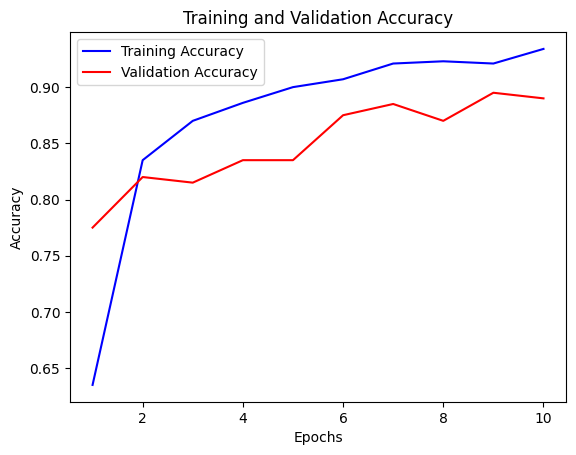

In [211]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)
# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b',label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [212]:
# assert model.history.history.get("accuracy")[-1] > 0.95

## Predict using fine-tuned VGG16 model

In [213]:
predictions = model.predict(x=test_batches, verbose=0)

In [214]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [215]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [216]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[45  5]
 [ 6 44]]


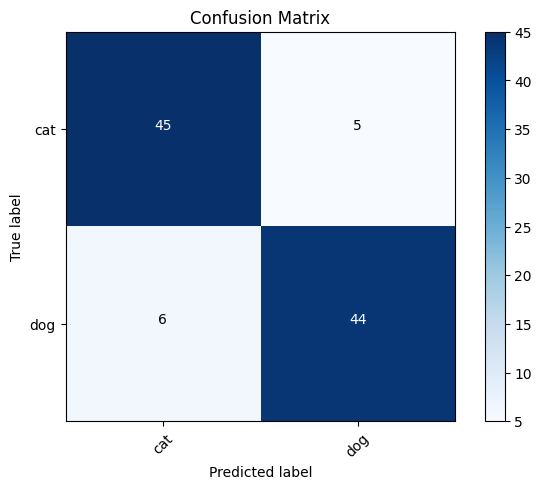

In [217]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [218]:
# # Given code snippet, there seems to be an error, iter not exhausting
# test_accuracy_values = []
# while True:
#     try:
#         test_data_batch, test_labels_batch = next(test_batches)
#         test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
#         test_accuracy_values.append(test_accuracy)
#     except StopIteration:
#         break # Break the loop when you've processed all batches

# # Calculate the overall test accuracy
# overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
# print("Overall Test Accuracy:", overall_test_accuracy)
   

test_accuracy_values = []
while len(test_accuracy_values) < test_batches.n:
    test_data_batch, test_labels_batch = next(test_batches)
    test_loss, test_accuracy = model.evaluate(test_data_batch, test_labels_batch)
    test_accuracy_values.append(test_accuracy)
    
# Calculate the overall test accuracy
overall_test_accuracy = sum(test_accuracy_values) / len(test_accuracy_values)
print("Overall Test Accuracy:", overall_test_accuracy)   

1/1 [==============================] - 0s 89ms/step - loss: 0.4663 - accuracy: 0.9375
Overall Test Accuracy: 0.859375


In [219]:
model.save("models/cats-vs-dogs.h5")